<a href="https://colab.research.google.com/github/alecbidaran/Deep-learning/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython import display

In [3]:

# Define global constants to be used in this notebook
BATCH_SIZE=128
LATENT_DIM=2


In [4]:
def map_image(image, label):
  '''returns a normalized and reshaped tensor from a given image'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(28, 28, 1,))
  
  return image


def get_dataset(map_fn, is_validation=False):
  '''Loads and prepares the mnist dataset from TFDS.'''
  if is_validation:
    split_name = "test"
  else:
    split_name = "train"

  dataset = tfds.load('mnist', as_supervised=True, split=split_name)
  dataset = dataset.map(map_fn)
  
  if is_validation:
    dataset = dataset.batch(BATCH_SIZE)
  else:
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE)

  return dataset

In [5]:
train_dataset = get_dataset(map_image)


In [6]:
class Sampling(tf.keras.layers.Layer):
  def call(self,inputs):
    mu,sigma=inputs
    batch=tf.shape(mu)[0]
    dim=tf.shape(mu)[1]
    epsilon=tf.keras.backend.random_normal(shape=(batch,dim))
    return mu+tf.exp(sigma*0.5)*epsilon

In [7]:
def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers.
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space

  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_2.shape -- shape of the features before flattening
  """

  # add the Conv2D layers followed by BatchNormalization
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation='relu', name="encode_conv1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="encode_conv2")(x)

  # assign to a different variable so you can extract the shape later
  batch_2 = tf.keras.layers.BatchNormalization()(x)

  # flatten the features and feed into the Dense network
  x = tf.keras.layers.Flatten(name="encode_flatten")(batch_2)

  # we arbitrarily used 20 units here but feel free to change and see what results you get
  x = tf.keras.layers.Dense(20, activation='relu', name="encode_dense")(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # add output Dense networks for mu and sigma, units equal to the declared latent_dim.
  mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
  sigma = tf.keras.layers.Dense(latent_dim, name ='latent_sigma')(x)

  return mu, sigma, batch_2.shape

In [8]:
def encoder_model(latent_dim, input_shape):
  """Defines the encoder model with the Sampling layer
  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """

  # declare the inputs tensor with the given shape
  inputs = tf.keras.layers.Input(shape=input_shape)

  # get the output of the encoder_layers() function
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=LATENT_DIM)

  # feed mu and sigma to the Sampling layer
  z = Sampling()((mu, sigma))

  # build the whole encoder model
  model = tf.keras.Model(inputs, outputs=[mu, sigma, z])

  return model, conv_shape

In [9]:
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layers.
  Args:
    inputs -- output of the encoder 
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """

  # feed to a Dense network with units computed from the conv_shape dimensions
  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units, activation = 'relu', name="decode_dense1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  
  # reshape output using the conv_shape dimensions
  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)

  # upsample the features back to the original dimensions
  x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_2")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_3")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid', name="decode_final")(x)
  
  return x

In [10]:
def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """

  # set the inputs to the shape of the latent space
  inputs = tf.keras.layers.Input(shape=(latent_dim,))

  # get the output of the decoder layers
  outputs = decoder_layers(inputs, conv_shape)

  # declare the inputs and outputs of the model
  model = tf.keras.Model(inputs, outputs)
  
  return model

In [11]:
def kl_reconstruction_loss(inputs,outputs,mu,sigma):
  kl=1+sigma*tf.square(mu)-tf.math.exp(sigma)
  return tf.reduce_mean(kl)*-0.5

In [12]:
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """

  # set the inputs
  inputs = tf.keras.layers.Input(shape=input_shape)

  # get mu, sigma, and z from the encoder output
  mu, sigma, z = encoder(inputs)
  
  # get reconstructed output from the decoder
  reconstructed = decoder(z)

  # define the inputs and outputs of the VAE
  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

  # add the KL loss
  loss = kl_reconstruction_loss(inputs, z, mu, sigma)
  model.add_loss(loss)

  return model

In [18]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
  decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
  vae = vae_model(encoder, decoder,input_shape)
  return encoder, decoder, vae

In [19]:
encoder, decoder, vae = get_models(input_shape=(28,28,1,), latent_dim=LATENT_DIM)
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [20]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """

  # generate images from the test input
  predictions = model.predict(test_input)

  # plot the results
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

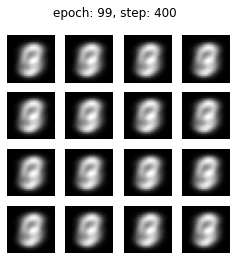

Epoch: 99 step: 400 mean loss = nan


In [22]:
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

# number of epochs
epochs = 100

# initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  for step,x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      reconstructed=vae(x_batch_train)
      flattened_input=tf.reshape(x_batch_train,shape=[-1])
      flattened_output=tf.reshape(reconstructed,shape=[-1])
      loss=bce_loss(flattened_input,flattened_output)*28*28
      loss+=sum(vae.losses)
    grads=tape.gradient(loss,vae.trainable_variables)
    optimizer.apply_gradients(zip(grads,vae.trainable_variables))
    loss_metric(loss)

    # display outputs every 100 steps
    if step % 100 == 0:
      display.clear_output(wait=False)    
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))